In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc


In [2]:
# Load all datasets
employee = pd.read_csv('/content/drive/MyDrive/HREmplyeeAttrition_Dataset/HR Employee data.csv')
survey = pd.read_csv('/content/drive/MyDrive/HREmplyeeAttrition_Dataset/Employee_office_survey.csv')
office = pd.read_csv('/content/drive/MyDrive/HREmplyeeAttrition_Dataset/Office_codes.csv')
job_roles = pd.read_csv('/content/drive/MyDrive/HREmplyeeAttrition_Dataset/Job_position_structure.csv')

In [4]:
# Aggregate Survey Data (Ratings)
survey_agg = survey.groupby('emp_id').agg({
    'rating': ['mean', 'min', 'max', 'std'],
    'rated_year': 'count'
}).reset_index()
survey_agg.columns = ['EmployeeID', 'avg_rating', 'min_rating', 'max_rating', 'rating_std', 'num_years_rated']

# Merge aggregated ratings into employee data
df = employee.merge(survey_agg, on='EmployeeID', how='left')

# Merge Officecodes Info
df = df.merge(office, on='office_code', how='left')


# Merge Job Roles
df = df.merge(job_roles, left_on=['Department', 'JobLevel_updated'], right_on=['Department', 'JobLevel'], how='left')
df.drop(['JobLevel'], axis=1, inplace=True)

# Drop Unnecessary Columns
drop_cols = ['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber', 'LeavingYear',
             'Reason', 'RelievingStatus', 'office_code']
df.drop(columns=drop_cols, errors='ignore', inplace=True)

# Handle Missing Values
df.fillna(df.median(numeric_only=True), inplace=True)

# Encode Categorical Columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

In [5]:

X = df.drop(columns=['Attrition'])
y = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [6]:
# Define the parameter grid for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_search.best_params_)



Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [7]:
# Evaluate the model with the best hyperparameters
best_model = grid_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4027

    accuracy                           1.00      4027
   macro avg       1.00      1.00      1.00      4027
weighted avg       1.00      1.00      1.00      4027



In [8]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on the model
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Average cross-validation score:", cv_scores.mean())

Cross-validation scores: [1. 1. 1. 1. 1.]
Average cross-validation score: 1.0


<Axes: xlabel='Attrition', ylabel='count'>

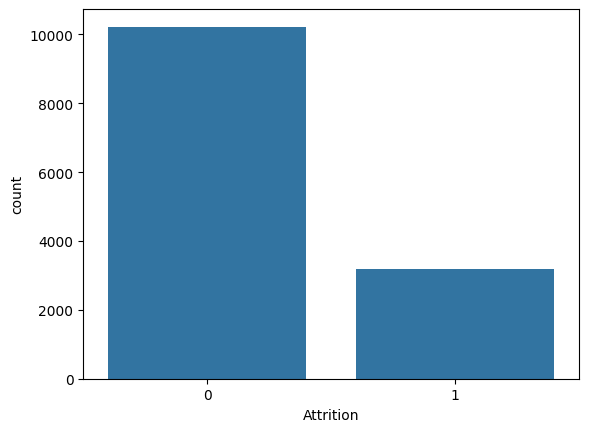

In [9]:
#how many employees leave or not
sns.countplot(data=df, x='Attrition')

<Axes: xlabel='Attrition', ylabel='avg_rating'>

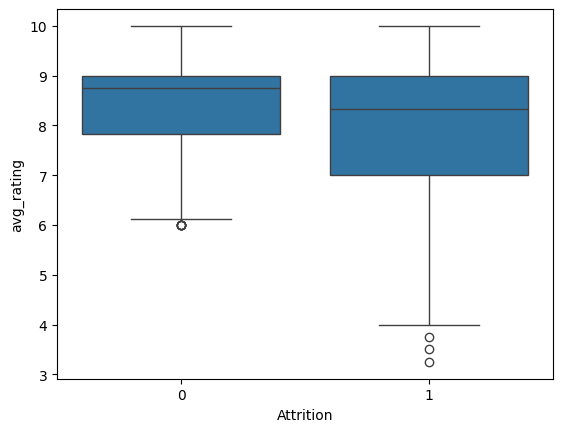

In [10]:
sns.boxplot(x='Attrition', y='avg_rating', data=df)
